# app code

In [2]:
import cv2
import ttg
from commonfunctions import *
import numpy as np
import skimage.io as io
import functools
# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

Image Retrieval

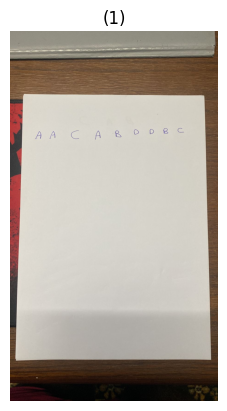

In [3]:
image=io.imread("./img/letters.png")
show_images([image])

Deskew and Presepective Transformation

In [4]:
# this helps to find the paper contour
def find_biggest_contours(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 10000:
            peri = cv2.arcLength(i, True)
            corners = cv2.approxPolyDP(i, 0.02 * peri, True)
            # to check that it is a rect and has the max area
            if area > max_area and len(corners) == 4:
                biggest = corners
                max_area = area
    return biggest
def Deskew(image): 
    img_original = image.copy()
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # reduce unwanted noise very well while keeping edges fairly sharp
    gray = cv2.bilateralFilter(gray, 50, 15, 15)
    edged = cv2.Canny(gray, 50, 50)
    kernel = np.ones((7, 7))
    dilatedImg = cv2.dilate(edged, kernel, iterations=2)
    edged = cv2.erode(dilatedImg, kernel, iterations=1)

    # Contour detection
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    Contour_Frames = img.copy()
    Contour_Frames = cv2.drawContours(Contour_Frames, contours, -1,  (0, 255, 0), 10)
    biggest_contours = find_biggest_contours(contours)
    new_img = cv2.drawContours(img, [biggest_contours], -1, (0, 255, 0), 3)

    # reorder corner pixels (src)
    points = biggest_contours.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]


    (top_left, top_right, bottom_right, bottom_left) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))

    # Output image size
    max_width = max(int(bottom_width), int(top_width))
    max_height = int(max_width * 1.414)  # for A4

    # Desired points values in the output image (dest)
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    # calculate the transformation matrix
    img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))
    #calculate the final image
    return img_output

Remove Black Edges (if Exist)

In [5]:
def remove_edges(img):
    image = img.copy()
    h = image.shape[0]
    w = image.shape[1]
    image=image[int(0.05*h):int(0.95*h), int(0.05*w):int(0.95*w)]
    image = cv2.resize(image,(w,h))
    return image

Expression Preprocessing

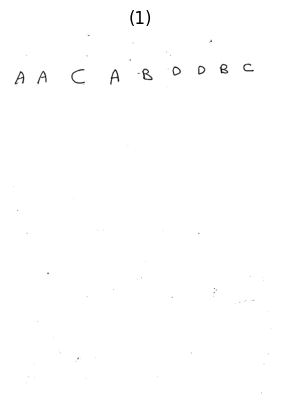

In [6]:

def expression_preprocessing(image):
    img=image.copy()
    Deskewed_image=Deskew(img)
    grey_Deskewed_image = cv2.cvtColor(Deskewed_image, cv2.COLOR_BGR2GRAY)
    '''
    the best thresholding of segmentation 
    applying adaptiveThreshold to differentiate the forground from background
    255 is the maxvalue
    cv2.ADAPTIVE_THRESH_MEAN is the adaptive method 
    cv2.THRESH_BINARY is the threshold type 
    '''
    img_Thresholded = cv2.adaptiveThreshold(grey_Deskewed_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 25, 5) 
    img_output=remove_edges(img_Thresholded)
    return img_output

expression_preprocessed=expression_preprocessing(image)
cv2.imwrite("./img/saved.png",expression_preprocessed)
show_images([expression_preprocessed])

Font Thickness

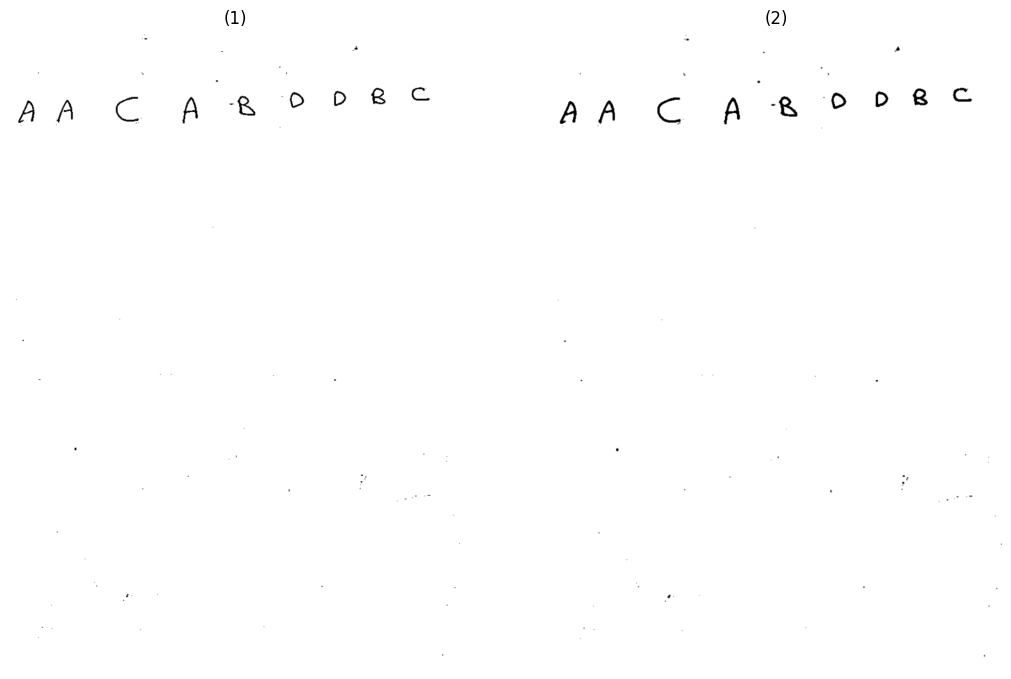

In [7]:
def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel,iterations=1)
    image = cv2.medianBlur(image, 3)
    return (image)
thick_image=thick_font(expression_preprocessed)
show_images([expression_preprocessed,thick_image])

In [8]:
print(ttg.Truths(['a', 'b'],['a xor b']))

+-----+-----+-----------+
|  a  |  b  |  a xor b  |
|-----+-----+-----------|
|  1  |  1  |     0     |
|  1  |  0  |     1     |
|  0  |  1  |     1     |
|  0  |  0  |     0     |
+-----+-----+-----------+


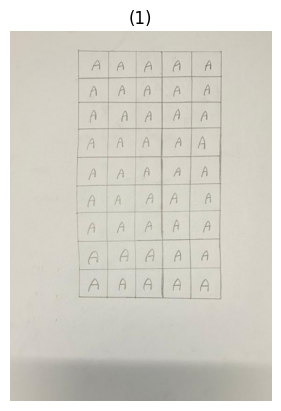

In [9]:
def Table_Preprocessing(image):
    image=Deskew(image)
    image=remove_edges(image)
    return image
    # table=Deskew(image)
    # return table
test=io.imread("./img/A.png")
table=Table_Preprocessing(test)
show_images([table])
#cv2.imwrite("./img/CB.png", table)
